# Getting Started with TensorFlow!
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/understandable-machine-intelligence-lab/Quantus/main?labpath=tutorials%2FTutorial_Getting_Started_with_Tensorflow.ipynb)


This notebook shows how to get started with Quantus with `tensorflow`. For this purpose, we use an EfficientNetV2 model and a subset of ImageNet dataset.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import quantus

tf.config.list_physical_devices()

2022-12-14 14:19:18.693987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1) Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [2]:
IMG_SIZE = 224

ds = tfds.load(
    "imagenet_v2",
    split=["test"],
    as_supervised=True,
    batch_size=8,
    data_dir="/tmp/tensorflow_datasets",
)

x_batch, y_batch = ds[0].skip(11).take(1).as_numpy_iterator().next()
x_batch = tf.image.resize(x_batch, (IMG_SIZE, IMG_SIZE)).numpy()
x_batch.shape

Metal device set to: AMD Radeon Pro 560


(8, 224, 224, 3)

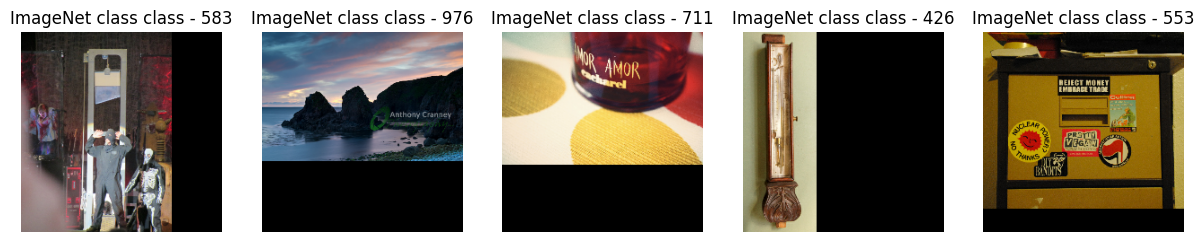

In [3]:
# Plot some inputs!
nr_images = 5
fig, axes = plt.subplots(
    nrows=1, ncols=nr_images, figsize=(nr_images * 3, int(nr_images * 2 / 3))
)
for i, (x, y) in enumerate(zip(x_batch[:nr_images], y_batch[:nr_images])):
    axes[i].imshow(x.astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class class - {y}")
    axes[i].axis("off")

### 1.2 Load a pre-trained model

In [4]:
model = tf.keras.applications.EfficientNetV2B0()

### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `tf-explain`.

In [5]:
# Generate Integrated Gradients attributions of the first batch of the test set.
y_predicted = model.predict(x_batch).argmax(axis=1)
a_batch_intgrad = quantus.explain(
    model, x_batch, y_predicted, method="IntegratedGradients"
)
a_batch_intgrad.shape

1/1 [==============================] - 2s 2s/step


(8, 224, 224)

Visualise attributions given model and pairs of input-output.

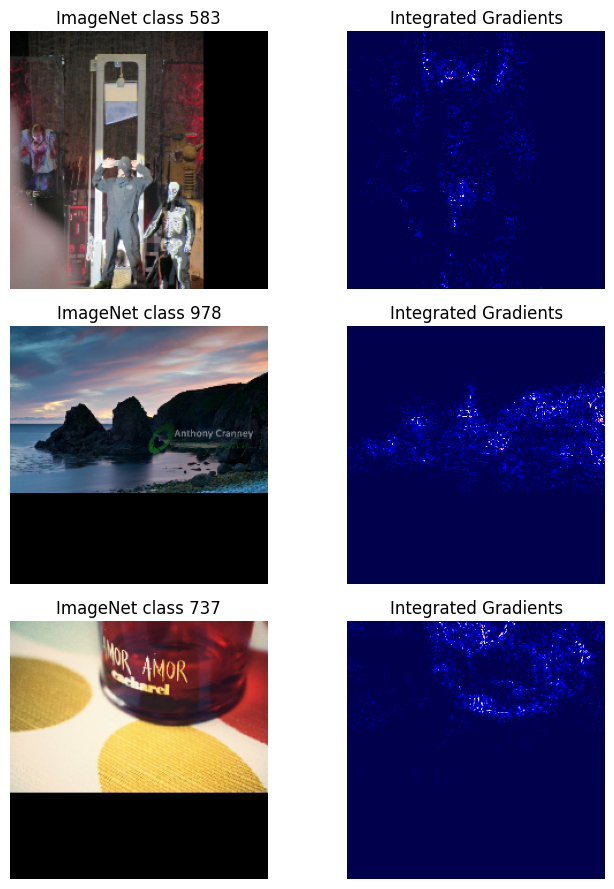

In [6]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(
    nrows=nr_images, ncols=2, figsize=(nr_images * 2.5, int(nr_images * 3))
)
for i, (x, y, a) in enumerate(
    zip(x_batch[:nr_images], y_predicted[:nr_images], a_batch_intgrad[:nr_images])
):
    axes[i, 0].imshow(x.astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i, 0].title.set_text(f"ImageNet class {y}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(a, cmap="seismic")
    axes[i, 1].title.set_text(f"Integrated Gradients")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

## 2) Quantative evaluation using Quantus

In [8]:
# We will use the same non-default hyperparameters for all metrics.
init_kwargs = dict(
    disable_warnings=True,
    display_progressbar=True,
    abs=True,
    normalise=True,
    nr_samples=5,
    return_nan_when_prediction_changes=True,
)

call_kwargs = dict(
    model=model,
    x_batch=x_batch,
    y_batch=y_predicted,
    a_batch=a_batch_intgrad,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "IntegratedGradients"},
    channel_first=True,
)

#### [MaxSensitivity](https://arxiv.org/pdf/2005.00631.pdf) (Umang Bhatt et al.)

This metric tests how the explanations maximally change while subject to slight perturbations.

In [9]:
# Instantiate metric.
max_sen = quantus.MaxSensitivity(**init_kwargs)
# Evaluate metric.
scores_intgrad_maxs = max_sen(**call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/helpers/warn.py:262: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


#### [AverageSensitivity](https://arxiv.org/pdf/2005.00631.pdf) (Umang Bhatt et al.)

This metric tests how the explanations change on average while subject to slight perturbations.

In [10]:
# Instantiate metric
avg_sen = quantus.AvgSensitivity(**init_kwargs)
# Evaluate metric
scores_intgrad_avg_sen = max_sen(**call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

#### [Relative Input Stability](https://arxiv.org/pdf/2203.06877.pdf) (Chirag Agarwal, et. al.)

Relative Input Stability leverages the changes in explanations, as a subject to change in inputs.

In [11]:
# Instantiate metric.
ris = quantus.RelativeInputStability(**init_kwargs)
# Evaluate metric.
ris_result = ris(**call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

#### [Relative Output Stability](https://arxiv.org/pdf/2203.06877.pdf) (Chirag Agarwal, et. al.)

Relative Output Stability leverages the changes in explanations, as a subject to change in output logits.

In [12]:
# Instantiate metric.
ros = quantus.RelativeOutputStability(**init_kwargs)
# Evaluate metric.
ros_result = ros(**call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

#### [Relative Representation Stability](https://arxiv.org/pdf/2203.06877.pdf) (Chirag Agarwal, et. al.)

Relative Representation Stability leverages the changes in explanations, as a subject to change in internal representations.
The authors of the paper didn't provide any code examples, neither did they specify which internal representations to take into account.
We expect RRS to be sensitive to this choice. So, let's try a few options out!

User can provide either layer_names or layer_indices as kwargs, to select, which layers' output should be taken into account.
Providing neither will force usage of all.

In [13]:
# Instantiate metric.
rrs_1 = quantus.RelativeRepresentationStability(**init_kwargs)
# Evaluate metric.
rrs_result_1 = rrs_1(**call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/helpers/model/tf_model.py:244: UserWarning: quantus.TensorFlowModel.get_hidden_layers_representations(...) received `layer_names`=None and `layer_indices`=None. This will force creation of tensorflow.keras.Model with outputs of each layer from original model. This can be very computationally expensive.
  warn(


In [14]:
# Instantiate metric.
rrs_2 = quantus.RelativeRepresentationStability(**init_kwargs, layer_names=["top_conv"])
# Evaluate metric.
rrs_result_2 = rrs_2(**call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# Instantiate metric.
rrs_3 = quantus.RelativeRepresentationStability(**init_kwargs, layer_indices=[3, 4, 5])
# Evaluate metric.
rrs_result_3 = rrs_3(**call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
pd.DataFrame(
    [
        scores_intgrad_maxs,
        scores_intgrad_avg_sen,
        ris_result,
        ros_result,
        rrs_result_1,
        rrs_result_2,
        rrs_result_3,
    ],
    index=[
        "MaxSensitivity",
        "AvgSensitivity",
        "Relative Input Stability",
        "Relative Output Stability",
        "Relative Representation Stability",
        "RRS(layer_names=top_conv)",
        "RRS(layer_indices=3, 4, 5)",
    ],
).aggregate([np.mean, np.std], axis=1)

,mean,std
MaxSensitivity,1.386801e-04,7.525040e-05
AvgSensitivity,1.393257e-04,7.540710e-05
Relative Input Stability,8.691818e+05,2.458417e+06
Relative Output Stability,7.834764e+07,1.251540e+07
Relative Representation Stability,2.975507e+01,8.379169e+01
RRS(layer_names=top_conv),7.720507e+04,4.476128e+04
"RRS(layer_indices=3, 4, 5)",1.682338e+03,1.191342e+03
